In [ ]:
#conda env export > environment.yml

In [1]:
import os
import re
import string
import pandas as pd 
import itertools

## import datasets

In [2]:
# import dataset
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
#target = pd.read_csv('train.csv', usecols=['target'])

In [3]:
print(len(df))
print(len(test_df))

7613
3263


In [4]:
test_df.drop(['id'], axis=1, inplace=True)
df.drop(['id'], axis=1, inplace=True)

In [5]:
#dups = df[df.duplicated(['text'])]
df.drop_duplicates(subset=['text'], keep='first', inplace=True)
test_df.drop_duplicates(subset=['text'], keep='first', inplace=True)

print(len(df))
print(len(test_df))

7503
3243


## visualize target data

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='solarizedl')

Text(0.5, 1.0, 'Binary Distribution of Disaster Tweet Dataset')

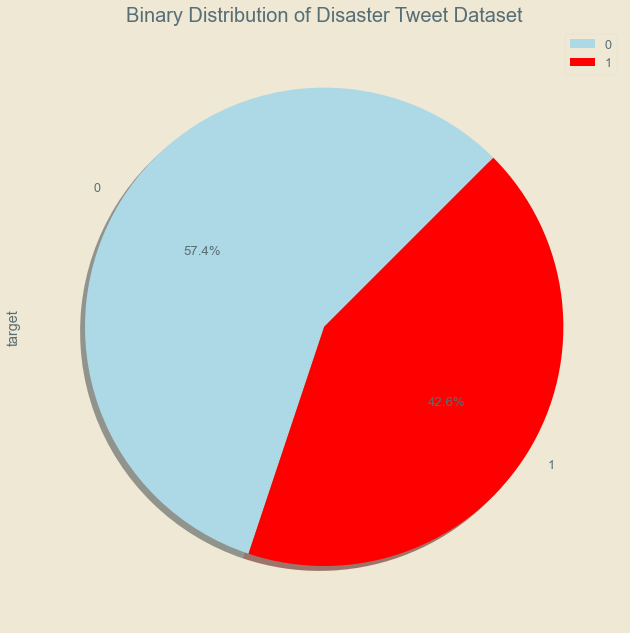

In [7]:
# visualize distribution of target in dataset
plt.figure(figsize=(11,11))
colors = ['lightblue', 'red']
expl = (0, 0.1)
df.target.value_counts().plot(kind='pie', legend=True, startangle=45, shadow=True, 
                             colors=colors, autopct='%1.1f%%')
plt.title('Binary Distribution of Disaster Tweet Dataset', fontsize=20)

# clean and process text

In [8]:
from symspellpy.symspellpy import SymSpell, Verbosity
import pkg_resources
from tqdm import tqdm

## hashtags

In [56]:
from spellchecker import SpellChecker

In [169]:
def spell_check_words(word):
    # lookup suggestions for multi word string input
    spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
    dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
    bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
    spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
    suggestions = spell.lookup_compound(word, max_edit_distance=2)
    closest = suggestions[0]
# display suggestion term, edit distance, and term frequency
    return closest.term

In [170]:
x = spell_check_words('thedog is otside')

In [171]:
x

'the dog is outside'

In [58]:
def spell_check_word(word):
    # lookup suggestions for individual words
    spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=5)
    dictionary_path = pkg_resources.resource_filename(
                      "symspellpy", "frequency_dictionary_en_82_765.txt")
    spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    corrections = spell.lookup(word, Verbosity.TOP)
    for correction in corrections:
        print(correction)

In [172]:
# functions related to expanded hashtags in text
def pascal_case_split(text):
    # expand hashtags formatted in pascal case, ex: #ThisIsPascal
    return re.sub(r'([A-Z])([?=a-z0-9+])', r' \1\2', text)

def camel_case_split(text):
    # expand hashtags formatted in pascal case, ex: #thisIsCamel
    return re.sub(r'([a-z0-9+])([?<=A-Z])', r'\1 \2', text)

def desegment_hashtag(text):
    spell = SymSpell(max_dictionary_edit_distance=0, prefix_length=7)
    dictionary_path = pkg_resources.resource_filename("symspellpy","frequency_dictionary_en_82_765.txt")
    spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    if text.isupper() | text.islower() and len(text)>8:
        result = spell.word_segmentation(text)
        text = result.corrected_string
    return text

def remove_hash(text):
    # remove hash symbol in front of hashtag text and remove non unicode chars
    return re.sub('#', '', text)

        
def expand_hashtags(text):
    # combine hashtag split functions for specific cases and remove hash
    c_text = camel_case_split(text)
    p_text = pascal_case_split(c_text)
    lu_text = desegment_hashtag(p_text)
    h_text = remove_hash(lu_text)
    return h_text

In [173]:
# create column for extracted hashtags
df['hashtags'] = df.text.str.findall(r'(?:(?<=\s)|(?<=^))#.*?(?=\s|$)')
test_df['hashtags'] = test_df.text.str.findall(r'(?:(?<=\s)|(?<=^))#.*?(?=\s|$)')
df.hashtags = df.hashtags.astype(str)
test_df.hashtags = test_df.hashtags.astype(str)

In [174]:
def expand_hashtags(text):
    # combine hashtag split functions for specific cases and remove hash
    c_text = camel_case_split(text)
    p_text = pascal_case_split(c_text)
    lu_text = spell_check_words(p_text)
    h_text = remove_hash(lu_text)
    return h_text

In [ ]:
%time
# with spell_check_words
df['exp_hash'] = df['hashtags'].map(expand_hashtags)

Wall time: 0 ns


In [ ]:
def expand_hashtags(text):
    # combine hashtag split functions for specific cases and remove hash
    c_text = camel_case_split(text)
    p_text = pascal_case_split(c_text)
    lu_text = desegment_hashtag(p_text)
    h_text = remove_hash(lu_text)
    return h_text

In [ ]:
%time
# with desegment_hashtag
df['exp_hash'] = df['hashtags'].map(expand_hashtags)

# process text

## dictionary based word replacement 

In [11]:
import csv

In [12]:
# import and read previously created dictionary as csv for abbreviations and expansions of words
def csv2dict(csv_name):
    with open(csv_name, mode='r') as f:
        reader = csv.reader(f)
        next(reader)
        return {rows[1]:rows[2] for rows in reader}
location_expansion_dict = csv2dict('utils\location_expansion.csv')
contractions_dict = csv2dict('utils\contractions.csv')

## denoise text

In [13]:
import html

In [21]:
def word_expansion_from_dict(text, expansion_dict):
    c_re = re.compile(r'\b'+r'\b|\b'.join(map(re.escape, expansion_dict.keys()))+r'\b')
    def replace(match):
        expansion =  f"{expansion_dict[match.group(0)]}"
        return expansion
    text = c_re.sub(replace, text)
    return text

def reduce_repeat_vowels(text, keep_reps=1):
    # function to reduce repeated vowel occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    vowels = ['a','e','i','o','u']
    for ch in iter(vowels):
        text = re.sub(r'(?i)'+rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def reduce_repeat_consonants(text, keep_reps=2):
    # function to reduce repeated consonant occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    consonants = ['b','c','d','f','g','h','j','k','l','m','n','p','q','r','s','t','v','w','x','y','z']
    for ch in iter(consonants):
        text = re.sub(r'(?i)'+ rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text
    
def remove_urls(text):
    # function to remove urls from string
    return re.sub(r"\S*http\S*",  r"", text)

def remove_handles(text):
    # function to remove twitter handles from string
    return re.sub("@\S*",  r" ", text)

def remove_non_uni(text):
    # function to remove non unicode characters from string
    return re.sub('[^\u0000-\u007f]', ' ', text)

def remove_nan_str(text):
    # function to remove 'nan' from string
    return re.sub('nan', '', text)

def remove_ws(text):
    return re.sub(' +', ' ', text)

def remove_non_alpha(text):
    # function to remove non alpha chars from string
    return re.sub("[^a-zA-Z]",  r" ", text)

def denoise_text(text):
    #remove urls
    text = remove_urls(text)
    #remove user handles
    text = remove_handles(text)
    #reduce repeating characters
    text = reduce_repeat_vowels(text)
    text = reduce_repeat_consonants(text)
    #remove xml tag strings
    text = html.unescape(text)
    #remove numeric and punctuation chars
    text = remove_non_alpha(text)
    #remove extra spaces
    text = remove_ws(text)
    return text   
    

## tokenize text

In [16]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

In [17]:
def nltk_tag_to_wordnet_tag(nltk_tag):
# function to convert nltk tag to wordnet tag
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    
def lemmatize_text(text):
    # define lemmatizer
    lemmatizer = WordNetLemmatizer()
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(text))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    # initialize empty list 
    lemmatized_text = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_text.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_text.append(lemmatizer.lemmatize(word, tag))
    return ' '.join(x for x in remove_stopwords(lemmatized_text) if len(x) > 2)


def remove_stopwords(tokens):
    # function to remove stopwords from text
    stop_list = stopwords.words('english')  
    new_tokens = []
    for word in tokens:
        if word not in stop_list:
            new_tokens.append(word)
    return new_tokens


## tweet text process

In [22]:
#### text preprocessing specifically formatted for tweets but will work on any text
def process_tweet(df): 
    """combine regex and nltk processing for tweet text and keyword text processing"""
    def expand_text(text):
        e_text = expand_hashtags(text)
        le_text = word_expansion_from_dict(e_text, expansion_dict=location_expansion_dict)
        ce_text = word_expansion_from_dict(le_text.lower(), expansion_dict=contractions_dict)
        return text

    def process_text(text):
        exp_text = expand_text(text)
        clean_text = denoise_text(exp_text)
        lem_text = lemmatize_text(clean_text)
        return lem_text

    processed_df = [process_text(x) for x in df]
    return processed_df

## keyword text process

In [23]:
def process_keyword(df):
    text = df.str.replace('%20', ' ')
    return text

## location text process

In [24]:
def process_location(df):
    """combine regex and nltk processing for location text processing"""
    
    def expand_text(text):
        exp_text = expand_hashtags(text) 
        loc_dict_lower = {k.lower(): v for k, v in location_expansion_dict.items()}
        exp_text = word_expansion_from_dict(exp_text.lower(), loc_dict_lower)
        return exp_text 
        
    def process_text(text):
        exp_text = expand_text(text)
        clean_text = denoise_text(exp_text)
        #lem_text = lemmatize_text(clean_text)
        return clean_text
    
    loc_df = [process_text(x) for x in df]
    return loc_df 

## create column containing combined column text & tokens columns

In [25]:
def combine_columns(df):
    df['clean_keyword'] = df.clean_keyword.astype(str)
    df['clean_keyword'] = df.clean_keyword.str.lower()
    df['clean_keyword'] = df.clean_keyword.str.replace(r'nan', r'')
    df['clean_location'] = df.clean_location.astype(str)
    df['clean_location'] = df.clean_location.str.lower()
    df['clean_location'] = df.clean_location.str.replace(r'nan', r'')
    df['tweets'] = df.tweets.astype(str)
    df['all_text'] = df['tweets'].str.cat(df['clean_location'],sep=" ")
    df['all_text'] = df['all_text'].str.cat(df['clean_keyword'],sep=" ")
    df['all_text'] = df['all_text'].str.strip()
    df['combined_tokens'] = df.all_text.str.lower()
    df['tweet_tokens'] = df.tweets.str.lower()
    df['combined_tokens'] = df.combined_tokens.apply(lambda row: row.split())
    df['tweet_tokens'] = df.tweet_tokens.apply(lambda row: row.split())
    new_df = df.drop(['keyword', 'location', 'text'], axis=1)
    return new_df

# create new dataframe applying above processes

In [77]:
%%time

df['tweets'] = process_tweet(df.text)
df['clean_keyword'] = process_keyword(df.keyword.astype(str))
df['clean_location'] = process_location(df.location.astype(str))
df.to_csv('train_lem.csv')
          
test_df['tweets'] = process_tweet(test_df.text)
test_df['clean_keyword'] = process_keyword(test_df.keyword.astype(str))
test_df['clean_location'] = process_location(test_df.location.astype(str))
test_df.to_csv('test_lem.csv')

Wall time: 4h 13min 55s


In [79]:
%%time

df2['tweets'] = df.text.apply(lambda x: (process_tweet(x) for x in df.text)
df2['clean_keyword'] = df.keyword.apply(lambda x: (process_keyword(x) for x in df.keyword)
df2['clean_location'] = df.location.apply(lambda x: (process_location(x) for x in df.location)
df2.to_csv('train_lem2.csv')
          
test_df2['tweets'] = test_df.text.apply(lambda x: (process_tweet(x) for x in test_df.text)
test_df2['clean_keyword'] = test_df.keyword.apply(lambda x: (process_keyword(x) for x in test_df.keyword)
test_df2['clean_location'] = test_df.location.apply(lambda x: (process_location(x) for x in test_df.location)

SyntaxError: invalid syntax (<unknown>, line 2)

In [42]:
train_df = combine_columns(df)
test_df2 = combine_columns(test_df)

In [40]:
df['tweets'] = df.tweets.astype(str)
df['tweets'] = df['tweets'].str.replace(r"_",  r" ")
df['tweets'] = df['tweets'].str.replace(r' +', r' ')
test_df['tweets'] = test_df.tweets.astype(str)
test_df['tweets'] = test_df['tweets'].str.replace(r"_",  r" ")
test_df['tweets'] = test_df['tweets'].str.replace(r' +', r' ')

<ipython-input-40-90328cf9f5f7>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tweets'] = df['tweets'].str.replace(r' +', r' ')
<ipython-input-40-90328cf9f5f7>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df['tweets'] = test_df['tweets'].str.replace(r' +', r' ')


In [43]:
len(train_df)

7503

In [44]:
train_df.drop_duplicates(subset=['tweets'], keep='first', inplace=True)
print('train samples: ',len(train_df))
test_df2.drop_duplicates(subset=['tweets'], keep='first', inplace=True)
print('test samples: ',len(test_df2))

train samples:  7334
test samples:  3203


In [49]:
from collections import Counter
from nltk.probability import FreqDist
from operator import itemgetter

In [80]:
word_dict = Counter(df.tweet_tokens.sum())
word_dict

Counter({'deed': 2,
         'reason': 31,
         'earthquake': 47,
         'may': 89,
         'allah': 7,
         'forgive': 4,
         'forest': 67,
         'fire': 371,
         'near': 55,
         'ronge': 1,
         'sask': 1,
         'canada': 15,
         'resident': 8,
         'ask': 33,
         'shelter': 7,
         'place': 34,
         'notify': 1,
         'officer': 38,
         'evacuation': 49,
         'order': 40,
         'expect': 33,
         'people': 198,
         'receive': 4,
         'wildfire': 82,
         'california': 138,
         'get': 440,
         'send': 51,
         'photo': 66,
         'ruby': 2,
         'alaska': 14,
         'smoke': 52,
         'pour': 4,
         'school': 69,
         'rocky': 14,
         'update': 54,
         'hwy': 10,
         'close': 36,
         'direction': 15,
         'due': 30,
         'lake': 17,
         'county': 40,
         'afire': 1,
         'flood': 150,
         'disaster': 157,
         '

In [81]:
num_words = sum(word_dict[w] for w in word_dict)
print(num_words)

69774


In [82]:
word_count_sorted = [(value, key) for key, value in word_dict.items()]
word_count_sorted.sort()

In [83]:
word_count_sorted

[(1, 'aal'),
 (1, 'aamir'),
 (1, 'aan'),
 (1, 'aannd'),
 (1, 'aarielle'),
 (1, 'aaron'),
 (1, 'aashiqui'),
 (1, 'aau'),
 (1, 'aavaye'),
 (1, 'abbandoned'),
 (1, 'abbruchsimulator'),
 (1, 'abby'),
 (1, 'abcnews'),
 (1, 'aberystwyth'),
 (1, 'abha'),
 (1, 'abhu'),
 (1, 'abj'),
 (1, 'abject'),
 (1, 'ableg'),
 (1, 'abndiv'),
 (1, 'aboard'),
 (1, 'abouts'),
 (1, 'abq'),
 (1, 'abs'),
 (1, 'absence'),
 (1, 'absolut'),
 (1, 'abstract'),
 (1, 'absurd'),
 (1, 'absurdly'),
 (1, 'abx'),
 (1, 'ac'),
 (1, 'acacia'),
 (1, 'academia'),
 (1, 'acai'),
 (1, 'accepte'),
 (1, 'accepts'),
 (1, 'accidentalprophecy'),
 (1, 'accompany'),
 (1, 'accordingly'),
 (1, 'accountable'),
 (1, 'accuracy'),
 (1, 'accustom'),
 (1, 'accustomed'),
 (1, 'acd'),
 (1, 'acesse'),
 (1, 'acf'),
 (1, 'ach'),
 (1, 'ache'),
 (1, 'achievement'),
 (1, 'achimota'),
 (1, 'aching'),
 (1, 'aci'),
 (1, 'ack'),
 (1, 'acne'),
 (1, 'acob'),
 (1, 'acquiesce'),
 (1, 'acronym'),
 (1, 'acrylic'),
 (1, 'actavis'),
 (1, 'actin'),
 (1, 'actively'),
 

In [86]:
corpus = list(word_dict.keys())

corpus_frequency = FreqDist(corpus)

corpus_commom=corpus_frequency.least_common()

AttributeError: 'FreqDist' object has no attribute 'least_common'

In [161]:
print(min(word_dict)[:100])

a


In [53]:
remove_words = [k for k,v in word_dict.items() if int(v) == 1]
te = [x for x in remove_words if len(x)>7]

In [55]:
te = [x for x in remove_words if len(x)>7]
te

['breaking',
 'africanbaze',
 'imaomknn',
 'barbados',
 'bridgetown',
 'superintende',
 'tracklist',
 'retainer',
 'superintendent',
 'deliberately',
 'teammate',
 'goodnight',
 'vandalized',
 'voortrekker',
 'farewell',
 'greeting',
 'publication',
 'tinderbox',
 'testicle',
 'personalinjury',
 'caraccidentlawyer',
 'stephenson',
 'overturned',
 'cabrillo',
 'magellan',
 'congestion',
 'mayonnaise',
 'ashville',
 'chandanee',
 'aashiqui',
 'aggarwal',
 'suffield',
 'langtree',
 'alternate',
 'financially',
 'hagerstown',
 'disciplinary',
 'bannister',
 'eisenhower',
 'remembers',
 'terrifying',
 'disclaimer',
 'lifehacks',
 'wiedemer',
 'silverwood',
 'biblestudy',
 'interrupt',
 'carnegie',
 'sandscrims',
 'mbataweel',
 'binladen',
 'unbelievably',
 'aeroplane',
 'naturally',
 'fletcher',
 'statistically',
 'aberystwyth',
 'shrewsbury',
 'nanotech',
 'justsaying',
 'randomthought',
 'nissonian',
 'hatzolah',
 'standardise',
 'clinical',
 'cleanest',
 'muschamp',
 'careworn',
 'entire

In [54]:
remove_words

['ronge',
 'sask',
 'notify',
 'afire',
 'manitou',
 'fvck',
 'breaking',
 'skiing',
 'hyxeoh',
 'xngw',
 'africanbaze',
 'epl',
 'imaomknn',
 'barbados',
 'bridgetown',
 'superintende',
 'eaj',
 'zji',
 'tjc',
 'kls',
 'ancop',
 'vida',
 'pumped',
 'preach',
 'ofx',
 'uli',
 'wbr',
 'tracklist',
 'retainer',
 'oucza',
 'superintendent',
 'lanford',
 'deliberately',
 'xarb',
 'noches',
 'bestia',
 'teammate',
 'goodnight',
 'trample',
 'vandalized',
 'diyala',
 'voortrekker',
 'tambo',
 'intl',
 'revel',
 'farewell',
 'gtx',
 'greeting',
 'pen',
 'publication',
 'jacinta',
 'mar',
 'navista',
 'tinderbox',
 'sjf',
 'ftc',
 'fvnxer',
 'testicle',
 'clara',
 'rwr',
 'personalinjury',
 'otley',
 'stlouis',
 'caraccidentlawyer',
 'curry',
 'herman',
 'stephenson',
 'overturned',
 'ramp',
 'junky',
 'ysxun',
 'ceh',
 'cabrillo',
 'magellan',
 'mir',
 'congestion',
 'spilt',
 'mayonnaise',
 'pissed',
 'donnie',
 'ashville',
 'median',
 'rlmy',
 'chandanee',
 'magu',
 'halfway',
 'turned',
 '

In [ ]:
test_df[test_df['text'].str.contains("#")]

In [ ]:
train_df[train_df['tweets'].str.contains("&")]


In [ ]:
df.loc[df['text'].str.contains("&amp")]